# LGBM

In [1]:
import pandas as pd
import numpy as np
import os
import random

import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

## 1. 데이터 로딩

In [2]:
data_dir = '/opt/ml/input/data/' # 경로는 상황에 맞춰서 수정해주세요!
csv_file_path = os.path.join(data_dir, 'all_feature_data.csv') # 데이터는 대회홈페이지에서 받아주세요 :)
df = pd.read_csv(csv_file_path)

# 2. Feature Engineering
- Special mission의 Feature Engineering 코드

In [3]:
df.groupby('userID')['answerCode'].transform(lambda x : x.cumsum())

df.groupby('userID')['answerCode'].transform(lambda x : type(x))

df.groupby('userID')['answerCode'].transform(lambda x : x.shift(1))

df['user_correct_answer'] = df.groupby('userID')['answerCode'].transform(lambda x: x.cumsum().shift(1))

df['user_total_answer'] = df.groupby('userID')['answerCode'].cumcount()

df['user_acc'] = df['user_correct_answer']/df['user_total_answer']

df.groupby(['testId'])['answerCode'].agg(['mean', 'sum'])

df.loc[:]

,Unnamed: 0,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,dataset,cumCorrect,cumAccuracy,tagCount,recAccuracy,user_correct_answer,user_total_answer,user_acc
0,0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,1,0.0,0.000000,0,1.000000,NaN,0,NaN
1,1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,1,1.0,1.000000,0,1.000000,1.0,1,1.000000
2,2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,1,2.0,1.000000,1,1.000000,2.0,2,1.000000
3,3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,1,3.0,1.000000,2,1.000000,3.0,3,1.000000
4,4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,1,4.0,1.000000,3,1.000000,4.0,4,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2526695,2526695,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,1,1.0,0.250000,4,0.200000,1.0,4,0.250000
2526696,2526696,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,1,1.0,0.200000,0,0.333333,1.0,5,0.200000
2526697,2526697,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,1,2.0,0.333333,1,0.428571,2.0,6,0.333333
2526698,2526698,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,1,3.0,0.428571,2,0.500000,3.0,7,0.428571


## TODO ##
의사결정
- user_correct_answer -> cumCorrect
- user_total_answer : csv 파일로 관리
- user_acc -> cumAccuracy
- test_mean : csv 파일로 관리
- test_sum : csv 파일로 관리
- tag_mean : csv 파일로 관리
- tag_sum : csv 파일로 관리

In [4]:
def feature_engineering(df):
    
    #유저별 시퀀스를 고려하기 위해 아래와 같이 정렬
    df.sort_values(by=['userID','Timestamp'], inplace=True)
    
    #유저들의 문제 풀이수, 정답 수, 정답률을 시간순으로 누적해서 계산
    df['user_correct_answer'] = df.groupby('userID')['answerCode'].transform(lambda x: x.cumsum().shift(1))
    df['user_total_answer'] = df.groupby('userID')['answerCode'].cumcount()
    df['user_acc'] = df['user_correct_answer']/df['user_total_answer']

    # testId와 KnowledgeTag의 전체 정답률은 한번에 계산
    # 아래 데이터는 제출용 데이터셋에 대해서도 재사용
    correct_t = df.groupby(['testId'])['answerCode'].agg(['mean', 'sum'])
    correct_t.columns = ["test_mean", 'test_sum']
    correct_k = df.groupby(['KnowledgeTag'])['answerCode'].agg(['mean', 'sum'])
    correct_k.columns = ["tag_mean", 'tag_sum']

    df = pd.merge(df, correct_t, on=['testId'], how="left")
    df = pd.merge(df, correct_k, on=['KnowledgeTag'], how="left")


    # 카테고리형 feature
    categories = ['assessmentItemID','testId']
    
    for category in categories :
        df[category] = df[category].astype('category')
    
    return df
df = feature_engineering(df)
df.head()

,Unnamed: 0,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,dataset,cumCorrect,cumAccuracy,tagCount,recAccuracy,user_correct_answer,user_total_answer,user_acc,test_mean,test_sum,tag_mean,tag_sum
0,0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,1,0.0,0.0,0,1.0,NaN,0,NaN,0.952667,1429,0.957333,718
1,1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,1,1.0,1.0,0,1.0,1.0,1,1.0,0.952667,1429,0.917067,3439
2,2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,1,2.0,1.0,1,1.0,2.0,2,1.0,0.952667,1429,0.917067,3439
3,3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,1,3.0,1.0,2,1.0,3.0,3,1.0,0.952667,1429,0.917067,3439
4,4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,1,4.0,1.0,3,1.0,4.0,4,1.0,0.952667,1429,0.917067,3439


In [6]:
train_df = df[df.dataset == 1]
train_df

,Unnamed: 0,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,dataset,cumCorrect,cumAccuracy,tagCount,recAccuracy,user_correct_answer,user_total_answer,user_acc,test_mean,test_sum,tag_mean,tag_sum
0,0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,1,0.0,0.000000,0,1.000000,NaN,0,NaN,0.952667,1429,0.957333,718
1,1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,1,1.0,1.000000,0,1.000000,1.0,1,1.000000,0.952667,1429,0.917067,3439
2,2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,1,2.0,1.000000,1,1.000000,2.0,2,1.000000,0.952667,1429,0.917067,3439
3,3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,1,3.0,1.000000,2,1.000000,3.0,3,1.000000,0.952667,1429,0.917067,3439
4,4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,1,4.0,1.000000,3,1.000000,4.0,4,1.000000,0.952667,1429,0.917067,3439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2526695,2526695,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,1,1.0,0.250000,4,0.200000,1.0,4,0.250000,0.666000,999,0.694889,3127
2526696,2526696,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,1,1.0,0.200000,0,0.333333,1.0,5,0.200000,0.652500,783,0.698551,2410
2526697,2526697,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,1,2.0,0.333333,1,0.428571,2.0,6,0.333333,0.652500,783,0.698551,2410
2526698,2526698,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,1,3.0,0.428571,2,0.500000,3.0,7,0.428571,0.652500,783,0.698551,2410


## 2. Train/Test 데이터 셋 분리

In [7]:
# train과 test 데이터셋은 사용자 별로 묶어서 분리를 해주어야함
random.seed(42)
def custom_train_test_split(df, ratio=0.8, split=True):
    
    users = list(zip(df['userID'].value_counts().index, df['userID'].value_counts()))
    random.shuffle(users)
    
    max_train_data_len = ratio*len(df)
    sum_of_train_data = 0
    user_ids =[]

    for user_id, count in users:
        sum_of_train_data += count
        if max_train_data_len < sum_of_train_data:
            break
        user_ids.append(user_id)


    train = df[df['userID'].isin(user_ids)]
    test = df[df['userID'].isin(user_ids) == False]

    #test데이터셋은 각 유저의 마지막 interaction만 추출
    test = test[test['userID'] != test['userID'].shift(-1)]
    return train, test

- FEATS 에 사용할 feature를 설정

In [8]:
# 유저별 분리
train, test = custom_train_test_split(train_df)

# TODO :사용할 Feature 설정
FEATS = [#'assessmentItemID',
        #'testId',
         'KnowledgeTag', 
         'user_total_answer',
         'test_mean',
         'test_sum',
         'tag_mean',
         'tag_sum',
         'cumCorrect',
         'cumAccuracy',
         #'tagCount',
         #'recAccuracy'
         ]

# X, y 값 분리
y_train = train['answerCode']
train = train.drop(['answerCode'], axis=1)

y_test = test['answerCode']
test = test.drop(['answerCode'], axis=1)

## 3. Dataset 정의

In [9]:
lgb_train = lgb.Dataset(train[FEATS], y_train)
lgb_test = lgb.Dataset(test[FEATS], y_test)

## 4. 훈련 및 검증

### hyper parameter 참고
- https://smecsm.tistory.com/133
- https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html

In [16]:
#hyper parameters
# TODO : tunning
params = {'learning_rate': 0.01,
          'max_depth':8,
          'boosting': 'gbdt', #
          'objective': 'binary',
          'metric': 'auc',
          'num_leaves': 40,
          'feature_fraction': 0.8,
          'bagging_fraction': 1,
          'bagging_freq': 5,
          'seed':42,
          }


model = lgb.train(
    params, 
    lgb_train,
    valid_sets=[lgb_train, lgb_test],
    verbose_eval=-1,
    num_boost_round=10000,
    early_stopping_rounds=100
)

preds = model.predict(test[FEATS])
acc = accuracy_score(y_test, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_test, preds)

print(f'VALID AUC : {auc} ACC : {acc}\n')

[LightGBM] [Info] Number of positive: 1187785, number of negative: 624671


[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1


LightGBMError: GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1

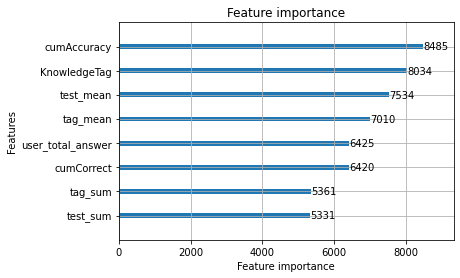

In [11]:
# INSTALL MATPLOTLIB IN ADVANCE
_ = lgb.plot_importance(model)

## 5. Inference

In [12]:
test_df = df[df.dataset == 2]

# LEAVE LAST INTERACTION ONLY
test_df = test_df[test_df['userID'] != test_df['userID'].shift(-1)]

# DROP ANSWERCODE
test_df = test_df.drop(['answerCode'], axis=1)

In [13]:
# MAKE PREDICTION
total_preds = model.predict(test_df[FEATS])

In [14]:
# SAVE OUTPUT
output_dir = 'output/'
write_path = os.path.join(output_dir, "submission.csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(total_preds):
        w.write('{},{}\n'.format(id,p))

writing prediction : output/submission.csv
